# Проект: Многоцелевая модель для NER + event-CLS

Этот Jupyter-ноутбук - пошаговый шаблон для выполнения проекта по объединённой (multi-task) модели, решающей **NER (BIO, token-level)** и **CLS (document-level multihot событий/отношений)** на датасете NEREL.

Внимание: вам нужно реализовать весь рабочий код - в ноутбуке предустановлены только парсеры строкового формата. Все остальные ячейки служат как инструкции / места для вашего кода.


#### Структура ноутбука 

1. Подготовка окружения (пути, seed, imports)
2. EDA - загрузка jsonl, обзор, графики, выводы 
3. Парсинг и таргеты - здесь уже есть парсеры строкового формата NEREL; нужно реализовать сбор примеров (`build_examples_from_nerel`) 
4. Токенизация, выравнивание меток, DataLoader - реализовать `tokenize_and_align_labels`, Dataset/Collator 
5. Модель (JointModel) и кастомный loss (uncertainty-weighting) - реализовать модельный класс и loss
6. Тренировка/валидация - training loop, оптимизатор, scheduler, логирование метрик
7. Инференс и анализ ошибок - реализовать inference pipeline и примеры



##### 1. EDA

Цели:

- Прочитать первые 50–200 записей `train.jsonl` (путь `/data/train.jsonl`).
- Посчитать частоты: entity types, relation/event types.
- Построить графики: топ-15 entity types, распределение длины текстов, число сущностей на документ.
- Написать 2–3 коротких вывода в Markdown: что можно ожидать при моделировании (редкие типы, длинные документы и т. п.).




In [ ]:
import os
import pandas as pd
import re
import matplotlib.pyplot as plt
from typing import List
from transformers import AutoTokenizer, AutoModel, DataCollatorForTokenClassification, get_linear_schedule_with_warmup
from typing import Optional, Dict, List
from sklearn.metrics import f1_score, precision_score, recall_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import warnings

warnings.filterwarnings('ignore')

e:\repos\multitarget_NER\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 1

data_path = '../NEREL'

In [3]:
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = True

In [4]:
data = pd.read_json(data_path + '/data/train.jsonl', encoding='utf-8', lines=True)

In [5]:
data

,id,text,entities,relations,links
0,0,"Пулеметы, автоматы и снайперские винтовки изъя...","[T1\tNATIONALITY 62 74\tамериканцами, T2\tCITY...","[R1\tTAKES_PLACE_IN Arg1:T70 Arg2:T12, R2\tAGE...","[N1\tReference T5 Wikidata:Q813\tКиргизия, N2\..."
1,1,Муртаза Рахимов чистит кадры\n\t\nПрезидент Ба...,"[T1\tPERSON 0 15\tМуртаза Рахимов, T2\tPROFESS...","[R1\tWORKS_AS Arg1:T3 Arg2:T76, R2\tWORKS_AS A...","[N1\tReference T9 Wikidata:NULL\t, N2\tReferen..."
2,2,Россия задерживает поставку генсека\n\t\nСегод...,"[T1\tCOUNTRY 0 6\tРоссия, T2\tCITY 48 52\tДохе...","[R1\tALTERNATIVE_NAME Arg1:T4 Arg2:T5, R2\tORG...",[N1\tReference T5 Wikidata:Q1031255\tФорум стр...
3,3,"Российские менеджеры отказались возглавлять ""г...","[T1\tCOUNTRY 0 10\tРоссийские, T2\tORGANIZATIO...","[R1\tALTERNATIVE_NAME Arg1:T80 Arg2:T4, R2\tAL...",[N1\tReference T3 Wikidata:Q6501749\tгенеральн...
4,4,Facebook нашел нового финансового директора\nФ...,"[T1\tORGANIZATION 0 8\tFacebook, T2\tPROFESSIO...","[R1\tAGE_IS Arg1:T6 Arg2:T5, R2\tALTERNATIVE_N...",[N1\tReference T13 Wikidata:Q899140\tGenentech...
...,...,...,...,...,...
741,741,Эрдоган: брюссельский террорист был ранее заде...,"[T1\tPERSON 0 7\tЭрдоган, T2\tCITY 9 21\tбрюсс...","[R1\tWORKS_AS Arg1:T13 Arg2:T44, R2\tWORKPLACE...",[N1\tReference T1 Wikidata:Q39259\tРеджеп Тайи...
742,742,Международный трибунал приговорил Радована Кар...,[T1\tORGANIZATION 0 22\tМеждународный трибунал...,"[R1\tTAKES_PLACE_IN Arg1:T36 Arg2:T10, R2\tCON...","[N1\tReference T5 Wikidata:NULL\t, N2\tReferen..."
743,743,Социальные сети — причина депрессии\n«Социальн...,[T1\tORGANIZATION 150 191\tМедицинской школы У...,"[R1\tWORKS_AS Arg1:T8 Arg2:T24, R2\tWORKS_AS A...","[N1\tReference T1 Wikidata:Q7896139\t, N2\tRef..."
744,744,Концерт Rolling Stones в Гаване собрал 500 тыс...,"[T1\tEVENT 0 7\tКонцерт, T2\tORGANIZATION 8 22...","[R1\tTAKES_PLACE_IN Arg1:T1 Arg2:T3, R2\tPOINT...",[N1\tReference T5 Wikidata:Q11036\tThe Rolling...


In [6]:
data['text'][0]

'Пулеметы, автоматы и снайперские винтовки изъяты в арендуемом американцами доме в Бишкеке\n\n05/08/2008 10:35\n\nБИШКЕК, 5 августа /Новости-Грузия/. Правоохранительные органы Киргизии обнаружили в доме, арендуемом гражданами США в Бишкеке, пулеметы, автоматы и снайперские винтовки, сообщает во вторник пресс-служба МВД Киргизии.\n\n"В ходе проведения оперативно-профилактического мероприятия под кодовым названием "Арсенал" в новостройке Ынтымак, в доме, принадлежащем 66-летнему гражданину Киргизии и арендуемом гражданами США, обнаружены и изъяты: шесть крупнокалиберных пулеметов с оптическим прицелом и с приборами ночного видения, 26 автоматов калибра 5,56 миллиметра, два винчестера марки МОСВЕГА 12-го калибра, четыре ствола от крупнокалиберного пулемета, два подствольных гранатомета, четыре снайперские винтовки с оптическим прицелом защитного цвета, шесть пистолетов калибра 9 миллиметров марки Беретта, одна винтовка", - говорится в сообщении МВД.\n\nПресс-служба отмечает, что на момент

In [7]:
data['entities'][0]

['T1\tNATIONALITY 62 74\tамериканцами',
 'T2\tCITY 82 89\tБишкеке',
 'T3\tDATE 117 126\t5 августа',
 'T4\tCOUNTRY 136 142\tГрузия',
 'T5\tORGANIZATION 145 179\tПравоохранительные органы Киргизии',
 'T6\tCOUNTRY 171 179\tКиргизии',
 'T7\tCOUNTRY 221 224\tСША',
 'T8\tCITY 227 234\tБишкеке',
 'T9\tDATE 288 298\tво вторник',
 'T10\tORGANIZATION 312 315\tМВД',
 'T11\tDATE 91 101\t05/08/2008',
 'T12\tCITY 433 440\tЫнтымак',
 'T13\tAGE 464 474\t66-летнему',
 'T14\tCOUNTRY 486 494\tКиргизии',
 'T15\tCOUNTRY 519 522\tСША',
 'T16\tNUMBER 545 550\tшесть',
 'T17\tNUMBER 631 633\t26',
 'T18\tNUMBER 652 667\t5,56 миллиметра',
 'T19\tNUMBER 669 672\tдва',
 'T20\tPRODUCT 690 697\tМОСВЕГА',
 'T21\tNUMBER 713 719\tчетыре',
 'T22\tNUMBER 758 761\tдва',
 'T23\tNUMBER 788 794\tчетыре',
 'T24\tNUMBER 855 860\tшесть',
 'T25\tNUMBER 880 893\t9 миллиметров',
 'T26\tPRODUCT 900 907\tБеретта',
 'T27\tNUMBER 909 913\tодна',
 'T28\tORGANIZATION 949 952\tМВД',
 'T29\tNUMBER 1098 1100\t10',
 'T30\tCOUNTRY 1136 1139\

In [8]:
entities_dict = {}

for entities in data['entities']:
    for entity in entities:
        re_text = re.findall('\t\w+\s', entity)[0][1:].strip(' ')
        if re_text in entities_dict:
            entities_dict[re_text] += 1
        else:
            entities_dict[re_text] = 1

In [9]:
# Частотности типов сущностей
sorted(entities_dict.items(), key=lambda item: item[1], reverse=True)

[('PERSON', 7779),
 ('PROFESSION', 7044),
 ('ORGANIZATION', 5776),
 ('EVENT', 4755),
 ('DATE', 3886),
 ('COUNTRY', 3633),
 ('CITY', 1846),
 ('NUMBER', 1496),
 ('AGE', 918),
 ('ORDINAL', 810),
 ('NATIONALITY', 629),
 ('AWARD', 603),
 ('FACILITY', 594),
 ('LAW', 574),
 ('STATE_OR_PROVINCE', 539),
 ('CRIME', 493),
 ('WORK_OF_ART', 492),
 ('IDEOLOGY', 446),
 ('PRODUCT', 409),
 ('LOCATION', 408),
 ('DISEASE', 387),
 ('PENALTY', 306),
 ('TIME', 260),
 ('MONEY', 253),
 ('DISTRICT', 160),
 ('RELIGION', 142),
 ('PERCENT', 102),
 ('LANGUAGE', 70),
 ('FAMILY', 32)]

In [10]:
relations_dict = {}

for relations in data['relations']:
    for relation in relations:
        re_text = re.findall('\t\w+\s', relation)[0][1:].strip(' ')
        if re_text in relations_dict:
            relations_dict[re_text] += 1
        else:
            relations_dict[re_text] = 1

In [11]:
# Частотности типов отношений
relations_dict

{'TAKES_PLACE_IN': 1599,
 'AGE_IS': 804,
 'HEADQUARTERED_IN': 1555,
 'ORGANIZES': 163,
 'LOCATED_IN': 1164,
 'OWNER_OF': 192,
 'SUBEVENT_OF': 319,
 'WORKPLACE': 3848,
 'ALTERNATIVE_NAME': 3696,
 'ORIGINS_FROM': 1404,
 'PART_OF': 396,
 'WORKS_AS': 3588,
 'MEMBER_OF': 369,
 'PLACE_RESIDES_IN': 225,
 'AGENT': 1136,
 'PARTICIPANT_IN': 3412,
 'POINT_IN_TIME': 1616,
 'SUBORDINATE_OF': 311,
 'IDEOLOGY_OF': 374,
 'HAS_CAUSE': 584,
 'KNOWS': 308,
 'ABBREVIATION': 192,
 'FOUNDED_BY': 175,
 'PLACE_OF_BIRTH': 106,
 'SCHOOLS_ATTENDED': 108,
 'CONVICTED_OF': 345,
 'PENALIZED_AS': 154,
 'DATE_OF_CREATION': 138,
 'INANIMATE_INVOLVED': 320,
 'DATE_OF_DEATH': 110,
 'CAUSE_OF_DEATH': 52,
 'EXPENDITURE': 37,
 'DATE_OF_BIRTH': 117,
 'PARENT_OF': 262,
 'PRICE_OF': 47,
 'SPOUSE': 140,
 'INCOME': 53,
 'START_TIME': 58,
 'END_TIME': 35,
 'PRODUCES': 553,
 'DATE_DEFUNCT_IN': 6,
 'MEDICAL_CONDITION': 272,
 'RELATIVE': 42,
 'AGE_DIED_AT': 104,
 'PLACE_OF_DEATH': 72,
 'DATE_FOUNDED_IN': 46,
 'AWARDED_WITH': 473,
 

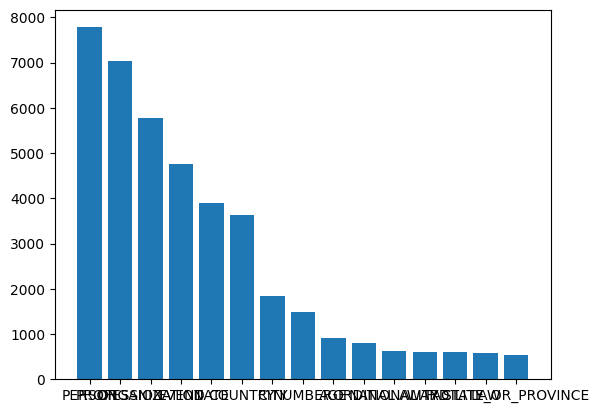

In [12]:
# Топ 15 типов сущностей

lists = sorted(entities_dict.items(), key=lambda item: item[1], reverse=True)[:15]

x, y = zip(*lists)

plt.bar(x, y)
plt.rcParams["figure.figsize"] = (20,5)
plt.show()

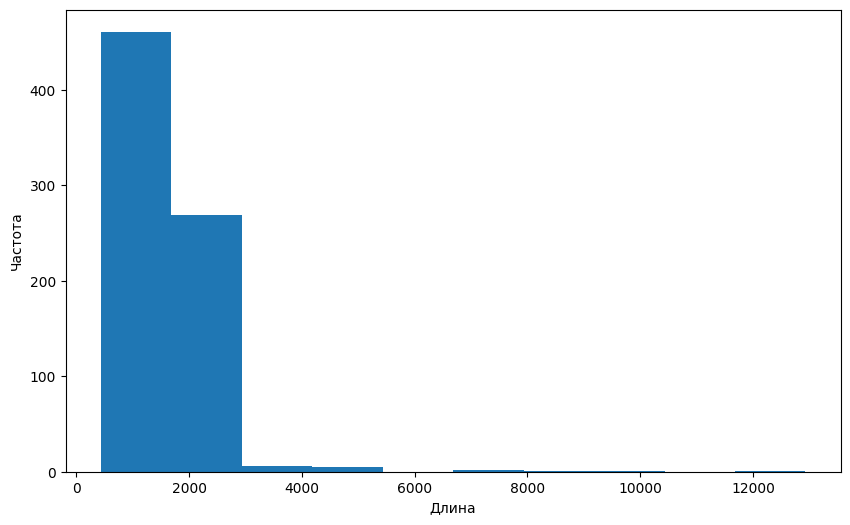

In [13]:
# Распределение длины текстов

y = [len(text) for text in data['text']]

plt.figure(figsize=(10, 6))
plt.hist(y)
plt.xlabel('Длина')
plt.ylabel('Частота')
plt.show()

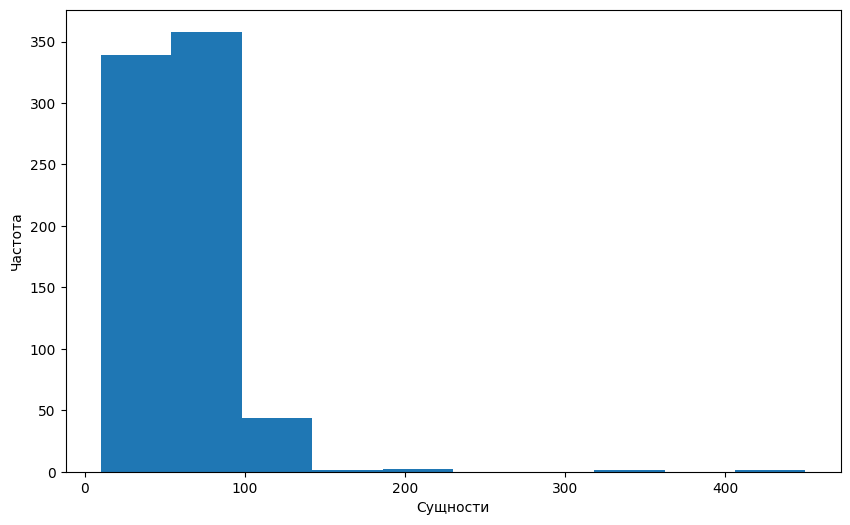

In [14]:
# Распределение кол-ва сущностей на документ

y = [len(entities) for entities in data['entities']]

plt.figure(figsize=(10, 6))
plt.hist(y)
plt.xlabel('Сущности')
plt.ylabel('Частота')
plt.show()

##### Выводы по EDA

- Самый частый тип сущности - PERSON (выделено почти 8000 сущностей этого типа среди 746 документов)

- Самые редкие типы сущностей - DISTRICT, RELIGION, PERCENT, LANGUAGE, FAMILY

- Среди документов есть несколько выбросов по длине текста и количеству выделенных сущностей

##### 2. Парсинг и подготовка таргетов

Ниже - две заранее подготовленные функции парсинга строкового формата NEREL. Их вы получаете и можете использовать сразу (не меняйте имена).

Ожидаемые дополнительные функции, которые вы должны реализовать:

- `build_examples_from_nerel(records: List[dict], event_list: List[str]) -> List[dict]` - для каждого документа вернуть словарь с полями: `text`, `tokens` (word-tokenization по пробелам), `token_spans` (символьные оффсеты слов), `tags` (BIO per token), `cls_vec` (multihot длиной len(event_list)).

- `make_event_list(records, K=30)` - собрать топ-K типов событий/relations и вернуть список.



**Правила BIO и сопоставления:**

- Токенизация для BIO - простая `text.split()` (по пробелам). Офсеты токенов вычисляются на основе поиска токена в тексте (учтите повторы; используйте скользящий указатель).
- Для каждой сущности (start, end - символьные оффсеты) пометьте токены, которые пересекаются с интервалом сущности.
- Метки: `B-TYPE`, `I-TYPE`, `O`.



In [15]:

import re
from collections import Counter

# Функции парсинга строкового формата NEREL
def parse_entity_line(line: str):
    parts = line.split('\t')
    if len(parts) < 3:
        return None
    ent_id = parts[0].strip()
    type_pos = parts[1].strip()
    text = parts[2].strip() if len(parts) > 2 else ''
    m = re.match(r'(\S+)\s+(\d+)\s+(\d+)', type_pos)
    if not m:
        return None
    ent_type = m.group(1)
    start = int(m.group(2))
    end = int(m.group(3))
    return {'id': ent_id, 'type': ent_type, 'start': start, 'end': end, 'text': text}

def parse_relation_line(line: str):
    parts = line.split('\t')
    if len(parts) < 2:
        return None
    rel_id = parts[0].strip()
    body = parts[1].strip()
    m = re.match(r'(\S+)\s+Arg1:(\S+)\s+Arg2:(\S+)', body)
    if not m:
        return None
    rel_type = m.group(1)
    arg1 = m.group(2); arg2 = m.group(3)
    return {'id': rel_id, 'type': rel_type, 'arg1': arg1, 'arg2': arg2}



In [16]:
def build_examples_from_nerel(data) -> List[dict]:

    examples = []
    for n, text in enumerate(data['text']):

        # Тексты
        tokens = []
        spans = []
        for m in re.finditer(r'\S+', text):
            tokens.append(m.group())
            spans.append((m.start(), m.end()))
            token_labels = ["O"] * len(tokens)

        # Сущности
        for line in data['entities'][n]:
            span = parse_entity_line(line)
            base_type = span['type']
            span_start = span['start']
            span_end = span['end']
            overlapping_idxs = []
            for i, (t_start, t_end) in enumerate(spans):
                if not (t_end <= span_start or t_start >= span_end):
                    overlapping_idxs.append(i)
            if not overlapping_idxs:
                continue
            for j, tok_idx in enumerate(overlapping_idxs):
                if token_labels[tok_idx] != "O":
                    continue
                prefix = "B" if j == 0 else "I"
                token_labels[tok_idx] = f"{prefix}-{base_type}"

        # Отношения
        rels = []
        cls_vec = []
        for line in data['relations'][n]:
            rels.append(parse_relation_line(line)['type'])

        all_types = list(relations_dict.keys())
        multihot = [0] * len(all_types)
        type_to_idx = {t: i for i, t in enumerate(all_types)}
        
        for rel in rels:
            if rel in type_to_idx:
                multihot[type_to_idx[rel]] = 1

        cls_vec = multihot
        

        examples.append({
        "text": text,
        "tokens": tokens,
        "token_spans": spans,
        "tags": token_labels,
        "cls_vec": cls_vec
        })

    return examples


In [17]:
examples = build_examples_from_nerel(data)

In [18]:
# Sanity check
examples[10:12]

[{'text': 'Москве потребовался год на поиски кандидата в генсеки "газовой ОПЕК"\nПравительство России после почти года поисков определилось со своим кандидатом на пост генерального секретаря Форума стран - экспортеров газа (ФСЭГ), который в прессе часто называют "газовой ОПЕК". Газета "Коммерсант" пишет, что российским кандидатом на пост главы ФСЭГ будет Леонид Бохановский, вице-президент компании "Стройтрансгаз". Ранее все потенциальные претенденты от России отказались бороться за предлагаемую им должность.\n\nГазета пишет, что своего кандидата на пост генсека ФСЭГ Россия представит в Дохе 9 ноября. Данная должность является ключевой для организации, поскольку занимающий этот пост человек должен обеспечивать разработку бюджета и программу форума, а также управлять его работой. Занять этот пост на два года российский кандидат сможет лишь в том случае, если его кандидатура будет одобрена единогласным решением всех министров энергетики стран-участниц форума.\n\nВ декабре 2008 года участн

In [19]:
def make_event_list(records, K=30):

    relations_dict = {}

    for relations in records['relations']:
        for relation in relations:
            re_text = re.findall('\t\w+\s', relation)[0][1:].strip(' ')
            if re_text in relations_dict:
                relations_dict[re_text] += 1
            else:
                relations_dict[re_text] = 1

    top_relations = sorted(entities_dict.items(), key=lambda item: item[1], reverse=True)
    
    return top_relations[:K]

In [20]:
# Топ 30 отношений
make_event_list(data)

[('PERSON', 7779),
 ('PROFESSION', 7044),
 ('ORGANIZATION', 5776),
 ('EVENT', 4755),
 ('DATE', 3886),
 ('COUNTRY', 3633),
 ('CITY', 1846),
 ('NUMBER', 1496),
 ('AGE', 918),
 ('ORDINAL', 810),
 ('NATIONALITY', 629),
 ('AWARD', 603),
 ('FACILITY', 594),
 ('LAW', 574),
 ('STATE_OR_PROVINCE', 539),
 ('CRIME', 493),
 ('WORK_OF_ART', 492),
 ('IDEOLOGY', 446),
 ('PRODUCT', 409),
 ('LOCATION', 408),
 ('DISEASE', 387),
 ('PENALTY', 306),
 ('TIME', 260),
 ('MONEY', 253),
 ('DISTRICT', 160),
 ('RELIGION', 142),
 ('PERCENT', 102),
 ('LANGUAGE', 70),
 ('FAMILY', 32)]

##### 3. Токенизация и выравнивание меток

Задачи:

- Выбрать `AutoTokenizer(..., use_fast=True)`.
- Реализовать `tokenize_and_align_labels(examples, tokenizer, label2id, max_length)`:
  - Токенизировать текст (return_offsets_mapping
  - Преобразовать word-level BIO метки в token-level метки (subword → label = -100 / ignore_index, для первых субтокенов ставится соответствующий тег `B-`/`I-`)
  - Вернуть словарь с `input_ids`, `attention_mask`, `labels` (token-level), `cls_labels`

- Собрать `torch.utils.data.Dataset` и `DataLoader`. Можно использовать `DataCollatorForTokenClassification` либо сделать кастомный collator, который возвращает батчи с `cls_labels`.



In [21]:
model_name = "DeepPavlov/rubert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [22]:
def align_labels(words, word_labels, tokenizer):
    subword_labels = []
    subword_input_ids = []
    subword_offsets = []

    for word, label in zip(words, word_labels):
        subwords = tokenizer.encode_plus(word, return_offsets_mapping=True, add_special_tokens=False)
        
        # if label == "O":
        #     subword_labels.extend([-100] * len(subwords['input_ids']))
        # else:
        subword_labels.append(label)
        subword_labels.extend([-100] * (len(subwords['input_ids']) - 1))
        
        for subword in subwords['input_ids']:
            subword_input_ids.append(subword)

        for subword in subwords['offset_mapping']:
            subword_offsets.append(subword)
    
    return subword_input_ids, subword_labels, subword_offsets

In [23]:
entity_list = sorted(entities_dict.items(), key=lambda item: item[1], reverse=True)

In [24]:
label2id = {}

label2id['O'] = 0

i = 1
for ent in entity_list:
    label2id['B-' + ent[0]] = i
    i += 1
    label2id['I-' + ent[0]] = i
    i += 1

In [25]:
len(label2id)

59

In [26]:

def tokenize_and_align_labels(examples, tokenizer, label2id, max_length=512):
    full_aligned_examples = []

    for i, example in enumerate(examples):
        aligned_example = {'input_ids' : [],
                           'attention_mask' : [],
                           'labels' : [],
                           'cls_labels' : []}
        subword_labels = []
        subword_input_ids = []
        subword_attention_mask = []

        words = example['tokens']
        word_labels = example['tags']

        for word, label in zip(words, word_labels):
            subwords = tokenizer.encode_plus(word, return_offsets_mapping=True, add_special_tokens=False)
            
            if label == "O":
                subword_labels.extend([-100] * len(subwords['input_ids']))
            else:
                subword_labels.append(label2id[label])
                subword_labels.extend([-100] * (len(subwords['input_ids']) - 1))
            
            for subword in subwords['input_ids']:
                subword_input_ids.append(subword)
            
            for subword in subwords['attention_mask']:
                subword_attention_mask.append(subword)

        aligned_example['input_ids'] = subword_input_ids[:max_length]
        aligned_example['attention_mask'] = subword_attention_mask[:max_length]
        aligned_example['labels'] = subword_labels[:max_length]
        aligned_example['cls_labels'] = examples[i]['cls_vec']

        full_aligned_examples.append(aligned_example)

    return full_aligned_examples


In [27]:
aligned_examples = tokenize_and_align_labels(examples, tokenizer, label2id)

In [28]:
len(aligned_examples[0]['input_ids'])

512

In [29]:
len(aligned_examples[0]['labels'])

512

In [30]:
len(aligned_examples[0]['cls_labels'])

49

In [31]:
class NERDataset(Dataset):
    def __init__(self, data, tokenizer, label2id):
        self.data = tokenize_and_align_labels(data, tokenizer, label2id)
        self.tokenizer = tokenizer
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

In [32]:
train_dataset = NERDataset(examples[:700], tokenizer, label2id)
test_dataset = NERDataset(examples[700:], tokenizer, label2id)

collator = DataCollatorForTokenClassification(tokenizer, padding=True, max_length=512)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=collator
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    collate_fn=collator
)


##### 4. Модель: `JointModel` + custom loss (uncertainty weighting)


In [33]:
class MetricsCalculator:
    def __init__(self, id2label: Dict[int, str]):
        self.id2label = id2label
        self.ner_labels = [label for label in id2label.values() if label != -100]
    
    def compute_ner_metrics(self, predictions: List[List[int]], labels: List[List[int]]):
        flat_predictions = []
        flat_labels = []
        
        for pred_seq, label_seq in zip(predictions, labels):
            for pred, label in zip(pred_seq, label_seq):
                if label != -100: # игнорируем -100
                    flat_predictions.append(pred)
                    flat_labels.append(label)
        
        token_f1_macro = f1_score(flat_labels, flat_predictions, average='macro', zero_division=0)
        token_precision_macro = precision_score(flat_labels, flat_predictions, average='macro', zero_division=0)
        token_recall_macro = recall_score(flat_labels, flat_predictions, average='macro', zero_division=0)
        
        
        return {
            'token_f1_macro': token_f1_macro,
            'token_precision_macro': token_precision_macro,
            'token_recall_macro': token_recall_macro,
        }
    
    def compute_relation_metrics(self, predictions: np.ndarray, labels: np.ndarray, threshold: float = 0.5):
        binary_predictions = (predictions > threshold).astype(int)
        
        micro_f1 = f1_score(labels.flatten(), binary_predictions.flatten(), average='micro', zero_division=0)
        micro_precision = precision_score(labels.flatten(), binary_predictions.flatten(), average='micro', zero_division=0)
        micro_recall = recall_score(labels.flatten(), binary_predictions.flatten(), average='micro', zero_division=0)
        
        return {
            'relation_micro_f1': micro_f1,
            'relation_micro_precision': micro_precision,
            'relation_micro_recall': micro_recall,
        }


In [34]:
class JointModel(nn.Module):
    def __init__(
        self,
        model_name: str,
        num_ner_labels: int,
        num_relation_labels: int,
        label2id: Dict[int, str],
        dropout_rate: float = 0.1,
        use_uncertainty_weight: bool = True
    ):
        super().__init__()
        
        self.use_uncertainty_weight = use_uncertainty_weight
        self.num_ner_labels = num_ner_labels
        self.num_relation_labels = num_relation_labels
        self.id2label = label2id
        self.metrics_calculator = MetricsCalculator(label2id)
        
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size
        
        self.dropout = nn.Dropout(dropout_rate)
        
        # Голова для NER
        self.token_cls = nn.Linear(hidden_size, num_ner_labels)
        
        # Голова для multi-hot вектора отношений
        self.cls_cls = nn.Linear(hidden_size, num_relation_labels)
        
        self.token_loss_fct = nn.CrossEntropyLoss(ignore_index=-100)
        self.cls_loss_fct = nn.BCEWithLogitsLoss()
        
        if use_uncertainty_weight:
            self.log_sigma_token = nn.Parameter(torch.tensor(0.0))
            self.log_sigma_cls = nn.Parameter(torch.tensor(0.0))
    
    def forward(
        self,
        input_ids: torch.Tensor,
        attention_mask: torch.Tensor,
        labels: Optional[torch.Tensor] = None,
        cls_labels: Optional[torch.Tensor] = None,
        return_metrics: bool = False
    ) -> Dict[str, torch.Tensor]:
        
        outputs = self.encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        
        sequence_output = outputs.last_hidden_state
        pooled_output = outputs.pooler_output
        
        sequence_output = self.dropout(sequence_output)
        pooled_output = self.dropout(pooled_output)
        
        token_logits = self.token_cls(sequence_output)
        
        cls_logits = self.cls_cls(pooled_output)
        
        result = {
            'token_logits': token_logits,
            'cls_logits': cls_logits
        }
        
        if labels is not None and cls_labels is not None:
            loss = self.compute_joint_loss(
                token_logits, cls_logits, 
                labels, cls_labels
            )
            result['loss'] = loss
            
            # Вычисляем метрики если требуется
            if return_metrics:
                metrics = self.compute_metrics(token_logits, cls_logits, labels, cls_labels)
                result.update(metrics)
        
        return result
    
    def compute_joint_loss(
        self,
        token_logits: torch.Tensor,
        cls_logits: torch.Tensor,
        labels: torch.Tensor,
        cls_labels: torch.Tensor
    ) -> torch.Tensor:
        
        token_logits = token_logits.float()
        cls_logits = cls_logits.float()
        labels = labels.long()
        cls_labels = cls_labels.float()
        
        token_loss = self.token_loss_fct(
            token_logits.view(-1, token_logits.size(-1)), 
            labels.view(-1)
        )
        
        cls_loss = self.cls_loss_fct(cls_logits, cls_labels)
        
        if self.use_uncertainty_weight:
            loss_token_term = torch.exp(-2.0 * self.log_sigma_token) * token_loss + self.log_sigma_token
            loss_cls_term = torch.exp(-2.0 * self.log_sigma_cls) * cls_loss + self.log_sigma_cls
            total_loss = loss_token_term + loss_cls_term
        else:
            total_loss = token_loss + cls_loss 
        
        return total_loss
    
    def compute_metrics(
        self,
        token_logits: torch.Tensor,
        cls_logits: torch.Tensor,
        labels: torch.Tensor,
        cls_labels: torch.Tensor
    ) -> Dict[str, float]:
        
        # NER
        ner_predictions = torch.argmax(token_logits, dim=-1).detach().cpu().numpy()
        ner_labels = labels.detach().cpu().numpy()
        
        # Relations
        relation_probs = torch.sigmoid(cls_logits).detach().cpu().numpy()
        relation_labels = cls_labels.detach().cpu().numpy()
        
        ner_metrics = self.metrics_calculator.compute_ner_metrics(
            ner_predictions.tolist(), 
            ner_labels.tolist()
        )
        
        relation_metrics = self.metrics_calculator.compute_relation_metrics(
            relation_probs, 
            relation_labels
        )
        
        return {**ner_metrics, **relation_metrics}

    def get_uncertainty_params(self) -> Dict[str, float]:
        if not self.use_uncertainty_weight:
            return {}
        
        return {
            'log_sigma_token': self.log_sigma_token.item(),
            'log_sigma_cls': self.log_sigma_cls.item(),
            'sigma_token': torch.exp(self.log_sigma_token).item(),
            'sigma_cls': torch.exp(self.log_sigma_cls).item(),
            'token_weight': torch.exp(-2.0 * self.log_sigma_token).item(),
            'cls_weight': torch.exp(-2.0 * self.log_sigma_cls).item()
        }


##### 5. Training / Validation



In [61]:
def evaluate(model, device='cuda'):
    
    # Оценка на тестовой выборке
    model.eval()

    test_metrics = {
    'token_f1_macro': [],
    'token_precision_macro': [],
    'token_recall_macro': [],
    'relation_micro_f1': [],
    'relation_micro_precision': [],
    'relation_micro_recall': []
    }

    with torch.no_grad():
        for batch in test_dataloader:
            batch = {
                'input_ids': batch['input_ids'].to(device, dtype=torch.long),
                'attention_mask': batch['attention_mask'].to(device, dtype=torch.long),
                'labels': batch['labels'].to(device, dtype=torch.long),
                'cls_labels': batch['cls_labels'].to(device, dtype=torch.float)
            }
            
            outputs = model(**batch, return_metrics=True)

            test_metrics['token_f1_macro'].append(outputs['token_f1_macro'])
            test_metrics['token_precision_macro'].append(outputs['token_precision_macro'])
            test_metrics['token_recall_macro'].append(outputs['token_recall_macro'])
            test_metrics['relation_micro_f1'].append(outputs['relation_micro_f1'])
            test_metrics['relation_micro_precision'].append(outputs['relation_micro_precision'])
            test_metrics['relation_micro_recall'].append(outputs['relation_micro_recall'])
        
        print(f"\n{'='*60}")
        print(f"ОЦЕНКИ НА ТЕСТОВОЙ ВЫБОРКЕ")
        print(f"\n{'='*60}")
        
        print("\nNER МЕТРИКИ:")
        print(f"  Token-Level Macro F1: {np.mean(test_metrics['token_f1_macro']):.4f}")
        print(f"  Token-Level Macro Precision: {np.mean(test_metrics['token_precision_macro']):.4f}")
        print(f"  Token-Level Macro Recall: {np.mean(test_metrics['token_recall_macro']):.4f}")
        
        print("\nRELATION МЕТРИКИ:")
        print(f"  Micro F1: {np.mean(test_metrics['relation_micro_f1']):.4f}")
        print(f"  Micro Precision: {np.mean(test_metrics['relation_micro_precision']):.4f}")
        print(f"  Micro Recall: {np.mean(test_metrics['relation_micro_recall']):.4f}")
    

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



Epoch 1

Эпоха 1 итоги:
  Loss: 2.7049
  token-level F1: 0.2186
  CLS micro-F1: 0.7666
  Uncertainty - Token sigma: 1.0017, CLS sigma: 1.0003

Epoch 2

Эпоха 2 итоги:
  Loss: 1.0054
  token-level F1: 0.6236
  CLS micro-F1: 0.8431
  Uncertainty - Token sigma: 1.0020, CLS sigma: 0.9972

Epoch 3

Эпоха 3 итоги:
  Loss: 0.7655
  token-level F1: 0.7600
  CLS micro-F1: 0.8392
  Uncertainty - Token sigma: 1.0016, CLS sigma: 0.9950

Epoch 4

Эпоха 4 итоги:
  Loss: 0.6609
  token-level F1: 0.8200
  CLS micro-F1: 0.8446
  Uncertainty - Token sigma: 1.0010, CLS sigma: 0.9937

Epoch 5

Эпоха 5 итоги:
  Loss: 0.6119
  token-level F1: 0.8472
  CLS micro-F1: 0.8447
  Uncertainty - Token sigma: 1.0008, CLS sigma: 0.9932


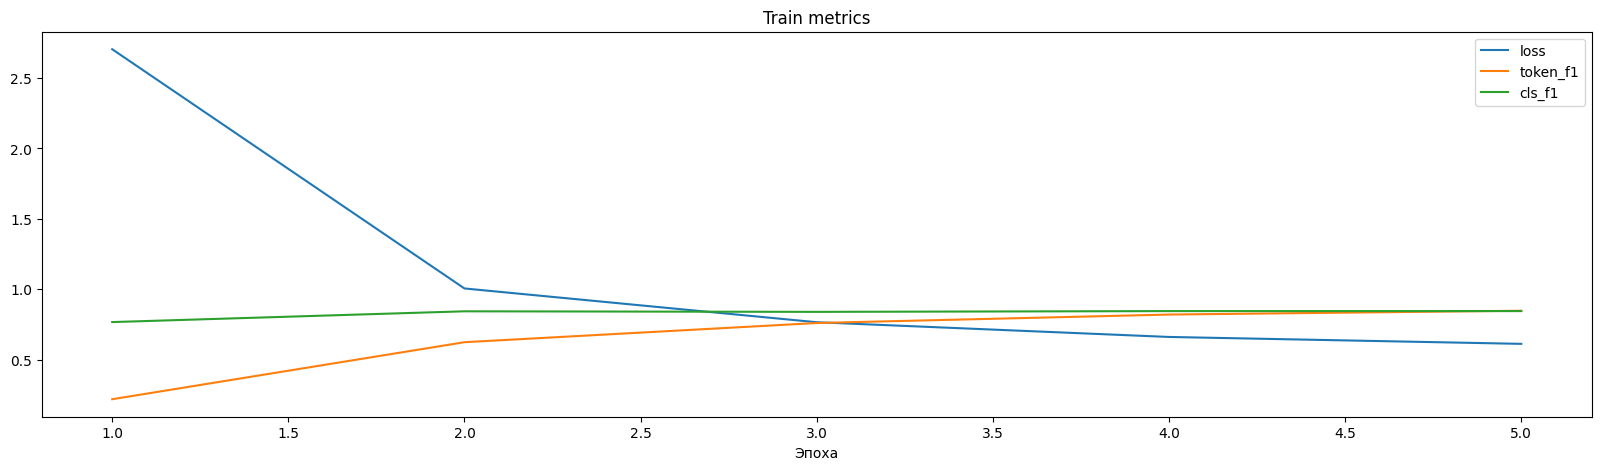


ОЦЕНКИ НА ТЕСТОВОЙ ВЫБОРКЕ


NER МЕТРИКИ:
  Token-Level Macro F1: 0.8155
  Token-Level Macro Precision: 0.8321
  Token-Level Macro Recall: 0.8264

RELATION МЕТРИКИ:
  Micro F1: 0.8265
  Micro Precision: 0.8265
  Micro Recall: 0.8265


In [36]:
def train(num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = JointModel(
        model_name=model_name,
        num_ner_labels=len(label2id),
        num_relation_labels=49,
        label2id=label2id
    )
    model.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    # LR scheduler
    num_training_steps = len(train_dataloader) * num_epochs
    num_warmup_steps = int(0.1 * num_training_steps)
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=num_warmup_steps,
        num_training_steps=num_training_steps
    )

    max_grad_norm = 1.0

    avg_loss = []
    avg_token_f1 = []
    avg_relation_f1 = []
    
    model.train()
    for epoch in range(num_epochs):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}")
        print(f"{'='*60}")
        
        epoch_metrics = {
            'loss': [],
            'token_f1_macro': [],
            'relation_micro_f1': []
        }
        
        for i, batch in enumerate(train_dataloader):
            batch = {
                'input_ids': batch['input_ids'].to(device, dtype=torch.long),
                'attention_mask': batch['attention_mask'].to(device, dtype=torch.long),
                'labels': batch['labels'].to(device, dtype=torch.long),
                'cls_labels': batch['cls_labels'].to(device, dtype=torch.float)
            }
            
            outputs = model(
                **batch,
                return_metrics=(i % 2 == 0)
            )
            
            loss = outputs['loss']
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
                                           
            optimizer.step()
            
            if scheduler:
                scheduler.step()

            optimizer.zero_grad()
            
            # Собираем метрики
            epoch_metrics['loss'].append(loss.item())
            
            if 'token_f1_macro' in outputs:
                epoch_metrics['token_f1_macro'].append(outputs['token_f1_macro'])
                epoch_metrics['relation_micro_f1'].append(outputs['relation_micro_f1'])
            
            # # Для каждого батча
            # if i % 1 == 0:
            #     print(f"Batch {i}: Loss = {loss.item():.4f}", end="")
                
            #     if 'token_f1_macro' in outputs:
            #         print(f" | NER Token F1: {outputs['token_f1_macro']:.4f} | Relation Micro F1: {outputs['relation_micro_f1']:.4f}")
            #     else:
            #         print()
        
        # Усредненные метрики за эпоху
        avg_loss.append(np.mean(epoch_metrics['loss']))
        avg_token_f1.append(np.mean(epoch_metrics['token_f1_macro']))
        avg_relation_f1.append(np.mean(epoch_metrics['relation_micro_f1']))
        
        print(f"\nЭпоха {epoch + 1} итоги:")
        print(f"  Loss: {avg_loss[epoch]:.4f}")
        print(f"  token-level F1: {avg_token_f1[epoch]:.4f}")
        print(f"  CLS micro-F1: {avg_relation_f1[epoch]:.4f}")
        
        if model.use_uncertainty_weight:
            params = model.get_uncertainty_params()
            print(f"  Uncertainty - Token sigma: {params['sigma_token']:.4f}, CLS sigma: {params['sigma_cls']:.4f}")

    # График с метриками
    y = np.arange(1, num_epochs + 1)

    plt.plot(y, avg_loss, label='loss')
    plt.plot(y, avg_token_f1, label='token_f1')
    plt.plot(y, avg_relation_f1, label='cls_f1')
    plt.title("Train metrics")
    plt.xlabel("Эпоха")
    plt.legend()
    plt.rcParams["figure.figsize"] = (7,5)
    plt.show()

    # Оценка на тестовой выборке
    evaluate(model)

    torch.save(model.state_dict(), 'model.pth')


train(num_epochs=5)



##### Выводы
Получены F1 для задачи распознавания именованных сущностей и классификации их отношений. Для достижения целевых значений метрик достаточно 3 эпохи.

##### 6. Инференс, квантизация и анализ ошибок

Проведите качественный анализ на 8–10 примерах: где NER ошибается? Какие типы сущностей плохо определяются? Насколько квантизация может ускорить инференс и сильно ли она ухудшает модель?


In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = JointModel(
        model_name=model_name,
        num_ner_labels=len(label2id),
        num_relation_labels=49,
        label2id=label2id
    )

model.load_state_dict(torch.load('model.pth'))
model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


JointModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [68]:
def predict(text, model, tokenizer, label2id, max_length=512):
    model.eval()
    
    encoding = tokenizer.encode_plus(
        text,
        return_offsets_mapping=True,
        return_tensors="pt",
        truncation=True,
        max_length=max_length,
        add_special_tokens=False
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        token_logits = outputs['token_logits']
        cls_logits = outputs['cls_logits']
        
        ner_predictions = torch.argmax(token_logits, dim=-1).squeeze().cpu().numpy()
        
        cls_probs = torch.sigmoid(cls_logits).squeeze().cpu().numpy()
    
    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().cpu().numpy())
    
    aligned_labels = []

    for pred_id in ner_predictions:
        aligned_labels.append(list(label2id.keys())[list(label2id.values()).index(pred_id)])

    # previous_word_idx = None
    # word_ids = encoding.word_ids()
    
    # for i, (token, pred_id) in enumerate(zip(tokens, ner_predictions)):
    #     word_idx = word_ids[i]
    #     if word_idx is None:
    #         aligned_labels.append("O")
    #     elif word_idx != previous_word_idx:
    #         aligned_labels.append(list(label2id.keys())[list(label2id.values()).index(pred_id)])
    #     else:
    #         aligned_labels.append("O")
        
    #     previous_word_idx = word_idx
    
    return {
        'tokens': tokens,
        'ner_predictions': aligned_labels,
        'cls_probabilities': cls_probs.tolist()
    }

In [ ]:
pred = predict(data['text'][0], model, tokenizer, label2id)

### Сравнение с квантизованной моделью (на cpu)

In [65]:
%time evaluate(model, device='cpu')


ОЦЕНКИ НА ТЕСТОВОЙ ВЫБОРКЕ


NER МЕТРИКИ:
  Token-Level Macro F1: 0.8155
  Token-Level Macro Precision: 0.8321
  Token-Level Macro Recall: 0.8264

RELATION МЕТРИКИ:
  Micro F1: 0.8265
  Micro Precision: 0.8265
  Micro Recall: 0.8265
CPU times: total: 55.5 s
Wall time: 9.27 s


In [58]:
quantized_model = torch.quantization.quantize_dynamic(
    model.to('cpu'), {torch.nn.Linear}, dtype=torch.qint8
)

In [64]:
%time evaluate(quantized_model, device='cpu')


ОЦЕНКИ НА ТЕСТОВОЙ ВЫБОРКЕ


NER МЕТРИКИ:
  Token-Level Macro F1: 0.8108
  Token-Level Macro Precision: 0.8240
  Token-Level Macro Recall: 0.8252

RELATION МЕТРИКИ:
  Micro F1: 0.8265
  Micro Precision: 0.8265
  Micro Recall: 0.8265
CPU times: total: 36.1 s
Wall time: 6.09 s


# Выводы

- При извлечении именованных сущностей модель чаще всего ошибается на типах сущностей, редко появляющихся в датасете.

- При квантизации линейных слоев модели снижение качества минимальное, но инференс ускоряется в 1.5 раза.